# Problem S4.4 


___"For a Si solar cell with a IL = 10 A, I0=2·10-11 A, n=1.2, estimate the value of Rs that produces a Pmax drop of 20% with respect to a cell without Rs. Do the same for Rp. Redo both calculations for a similar cell but with half the Isc, and compare the results"___

First, we import the Python modules used and define one constant to set the I-V curve data size, and the Boltzman constant

In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt

DATA_SIZE = 500
kB = 8.617333e-5  # eV·K-1

We define the variables for the I-V curve data

In [13]:
# These are values in the usual range for a typical 16.6 x 16.6 cm2 Si solar cell
IL = 10.0 # A
I0 = 2e-9 # A
n = 1.2

temperature = 25  
cell_area = 16.6*16.6 # cm2

Now we define a useful function to calculate the I-V curve of the solar cell.
Note that we use a number of datapoints defined as the constant DATA_SIZE. The larger this number, the more precisión, but also the longer computation time. Since the calculations are not complicated, you can use large numbers with almost instantenous calculations in modern desktop computers or laptops.

In [14]:
def model_IV(IL, I0, n, Rs, Rp, temperature):
    # Thermal voltage
    kBT = kB*(temperature + 273.15)
    
    #I-V curve stored in a 2-column array: first column for voltages, second column for currents
    IVcurve = np.zeros((DATA_SIZE,2))
    
    # First we calculate the I-V curve voltage range: from -0.1 V to Voc + 0.01 V
    # We want to have the I-V curve crossing the current and voltage axis to see the Isc and Voc
    #Voc without Rs/Rp.
    Voc0 = n*kBT*math.log(IL/I0)
    
    #Create the voltage list
    #Voltage range used: -0.1 to Voc+0.01
    IVcurve[:,0]= np.linspace(-0.1, Voc0+0.01, DATA_SIZE)
    
    #I-V curve without Rs effect
    IVcurve[:,1] = IL - I0*(np.exp(IVcurve[:,0]/(n*kBT))-1) - IVcurve[:,0]/Rp
    
    #Shift voltages to include Rs effect
    IVcurve[:,0] = IVcurve[:,0] - Rs*IVcurve[:,1]
    
    return IVcurve

And another function to get the Pmax. <br>
Note that this function does not assume that the I-V curve is in the first quadrant. Another two functions are used to calculate the Isc and Voc and detect the quadrant. Then, the function calculating Pmax moves the I-V curve to this quadrant, if it is not there yet. 

In [15]:
# Obtains Isc by linear interpolation around V=0
def get_Isc(IVdata):
    """Returns the Isc of the input raw I-V curve"""

   # Sort data (interpolation function requires sorted data)
    IV_sorted = IVdata.copy()
    IV_sorted=IVdata[IVdata[:,0].argsort()] #Sort by voltages  
    
    Isc = np.interp(0,IV_sorted[:,0],IV_sorted[:,1])
    
    return Isc

# Obtains Voc by linear interpolation around I=0
def get_Voc(IVdata):
    """Returns the Voc of the input raw I-V curve"""

   # Sort data (interpolation function requires sorted data)
    IV_sorted = IVdata.copy()
    IV_sorted=IVdata[IVdata[:,1].argsort()]   #Sort by currents
    
    Voc = np.interp(0, IV_sorted[:,1],IV_sorted[:,0])
    
    return Voc

# Obtains the Pmax, and also the Vm and Im
def get_Pmax(IVdata):
  
   # Sort data and move to 1st quadrant
    IV_sorted = IVdata.copy()
 
    Isc = get_Isc(IV_sorted)
    if Isc<0:
        Isc*=-1
        IV_sorted[:,1]*=-1
    
    Voc = get_Voc(IV_sorted)
    if Voc<0:
        Voc*=-1
        IV_sorted[:,0]*=-1       
 
    IV_sorted=IV_sorted[IV_sorted[:,0].argsort()]   
   
 
    PV = IV_sorted.copy()
    PV[:,1] = IV_sorted[:,0]*IV_sorted[:,1]
    
    Pm = np.amax(PV[:,1])
    maxPosition = np.argmax(PV[:,1])
    Vm = PV[maxPosition,0]
    Im = IV_sorted[maxPosition,1]

    return Pm, Vm, Im



We make a graph of normalized Pmax vs Rs for the two solar cell Isc and calculate the values of Rs that cause a 20% Pmax loss

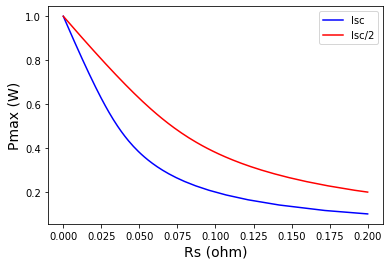

Solar cell with IL=1e+01: for an Rs=0.0128 Ω (3.54 Ω·cm2)  the Pmax loss is 20%
Solar cell with IL=5.0: for an Rs=0.0257 Ω (7.08 Ω·cm2)  the Pmax loss is 20%


In [16]:
# Two-column arrays for Pmax vs Rs
# Create the Rs list in the first colum
Rs_min = 0  # ohm
Rs_max = 0.2 # ohm
Pmax_vs_Rs = np.zeros((DATA_SIZE,2))
Pmax_vs_Rs[:,0] = np.linspace(Rs_min, Rs_max, DATA_SIZE)
Pmax_vs_Rs_halfIsc = np.zeros((DATA_SIZE,2))
Pmax_vs_Rs_halfIsc[:,0] = np.linspace(Rs_min, Rs_max, DATA_SIZE)

# Calculate the Pmax for the list of Rs
for x in range(DATA_SIZE):
    IV_curve = model_IV(IL, I0, n, Pmax_vs_Rs[x,0], 1e6, temperature)
    Pm, Vm, Im = get_Pmax(IV_curve)
    Pmax_vs_Rs[x,1] = Pm

    IV_curve = model_IV(IL/2, I0/2, n, Pmax_vs_Rs_halfIsc[x,0], 1e6, temperature)
    Pm, Vm, Im = get_Pmax(IV_curve)
    Pmax_vs_Rs_halfIsc[x,1] = Pm

# Normalize the Pmax: divide data by maximum value
Pmax_vs_Rs[:,1] =  Pmax_vs_Rs[:,1]/Pmax_vs_Rs[0,1]  
Pmax_vs_Rs_halfIsc[:,1] =  Pmax_vs_Rs_halfIsc[:,1]/Pmax_vs_Rs_halfIsc[0,1]  

# Plot the data
plt.plot(Pmax_vs_Rs[:,0], Pmax_vs_Rs[:,1], color='b', label='Isc')
plt.plot(Pmax_vs_Rs_halfIsc[:,0], Pmax_vs_Rs_halfIsc[:,1], color='r', label='Isc/2')
plt.xlabel('Rs (ohm)', size=14)
plt.ylabel('Pmax (W)', size=14)
plt.legend()
plt.show()

# Report the values
Pm_sorted=Pmax_vs_Rs[Pmax_vs_Rs[:,1].argsort()]
Rs_20loss = np.interp(0.8, Pm_sorted[:,1],Pm_sorted[:,0])
sResult = "Solar cell with IL="+ f"{IL:.1}" + ": for an Rs="+ f"{Rs_20loss:.3}" + " \u03A9" 
sResult += " (" + f"{Rs_20loss*cell_area:.3}" + " \u03A9·cm2) " + " the Pmax loss is 20%"
print(sResult)

Pm_sorted=Pmax_vs_Rs_halfIsc[Pmax_vs_Rs_halfIsc[:,1].argsort()]
Rs_20loss = np.interp(0.8, Pm_sorted[:,1],Pm_sorted[:,0])
sResult = "Solar cell with IL="+ str(IL/2) + ": for an Rs="+f"{Rs_20loss:.3}"+ " \u03A9"
sResult += " (" + f"{Rs_20loss*cell_area:.3}" + " \u03A9·cm2) " + " the Pmax loss is 20%"
print(sResult)
    

As you can see, the Isc determines how the Rs affects the solar cell performance. For higher currents, the Rs creates a higher power loss. <br>
IMPORTANT NOTE: the Rs is given also as a value per unit area, since it is frequent to find it that way.

Now we do a similar thing with Rp

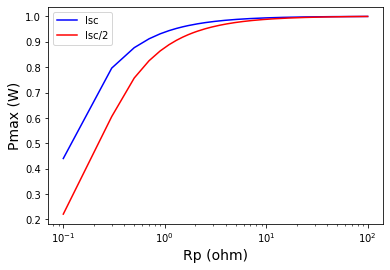

Solar cell with IL=10.0: for an Rp=0.309 Ω (85.162 Ω·cm2)  the Pmax loss is 20%
Solar cell with IL=5.0: for an Rp=0.626 Ω (172.380 Ω·cm2)  the Pmax loss is 20%


In [17]:
# Two-column arrays for Pmax vs Rs
# Create the Rp list in the first colum
Rp_min = 0.1 # ohm
Rp_max = 100 # ohm
Pmax_vs_Rp = np.zeros((DATA_SIZE,2))
Pmax_vs_Rp[:,0] = np.linspace(Rp_min, Rp_max, DATA_SIZE)
Pmax_vs_Rp_halfIsc = np.zeros((DATA_SIZE,2))
Pmax_vs_Rp_halfIsc[:,0] = np.linspace(Rp_min, Rp_max, DATA_SIZE)

# Calculate the Pmax for the list of Rp
for x in range(DATA_SIZE):
    IV_curve = model_IV(IL, I0, n, 0 , Pmax_vs_Rp[x,0], temperature )
    Pm, Vm, Im = get_Pmax(IV_curve)
    Pmax_vs_Rp[x,1] = Pm

    IV_curve = model_IV(IL/2, I0/2, n, 0, Pmax_vs_Rp_halfIsc[x,0], temperature)
    Pm, Vm, Im = get_Pmax(IV_curve)
    Pmax_vs_Rp_halfIsc[x,1] = Pm

# Normalize: divide by max Pmax
Pmax_vs_Rp[:,1] =  Pmax_vs_Rp[:,1]/Pmax_vs_Rp[DATA_SIZE-1,1]  
Pmax_vs_Rp_halfIsc[:,1] =  Pmax_vs_Rp_halfIsc[:,1]/Pmax_vs_Rp_halfIsc[DATA_SIZE-1,1]  

# Plot the data
plt.plot(Pmax_vs_Rp[:,0], Pmax_vs_Rp[:,1], color='b', label='Isc')
plt.plot(Pmax_vs_Rp_halfIsc[:,0], Pmax_vs_Rp_halfIsc[:,1], color='r', label='Isc/2')
plt.xlabel('Rp (ohm)', size=14)
plt.ylabel('Pmax (W)', size=14)
# Use logarithmic scale for Rp axis to see data better
plt.xscale("log")
plt.legend()
plt.show()

# Report values
Pm_sorted=Pmax_vs_Rp[Pmax_vs_Rp[:,1].argsort()]
Rp_20loss = np.interp(0.8, Pm_sorted[:,1],Pm_sorted[:,0])
sResult = "Solar cell with IL="+ str(IL) + ": for an Rp="+f"{Rp_20loss:.3}"+ " \u03A9"
sResult += " (" + f"{Rp_20loss*cell_area:.3f}" + " \u03A9·cm2) " + " the Pmax loss is 20%"
print(sResult)

Pm_sorted=Pmax_vs_Rp_halfIsc[Pmax_vs_Rp_halfIsc[:,1].argsort()]
Rp_20loss = np.interp(0.8, Pm_sorted[:,1],Pm_sorted[:,0])
sResult = "Solar cell with IL="+ str(IL/2) + ": for an Rp="+f"{Rp_20loss:.3}" + " \u03A9"
sResult += " (" + f"{Rp_20loss*cell_area:.3f}" + " \u03A9·cm2) " + " the Pmax loss is 20%"
print(sResult)
    

As you can see, the Isc determines how the Rp affects the solar cell performance. For lower currents, a low Rp creates a higher power loss. <br>
IMPORTANT NOTE: the Rp is given also as a value per unit area, since it is frequent to find it that way.